## Model 5:
 - 150 x 150 x 3
 - mini_batch size = 512
 - 20 epochs
 - pretrained layers with mobile net v2
 - +6 top layers

In [1]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.models import Sequential
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

import os
from os import listdir
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
base_directory = "skin-cancer-mnist-ham10000"

test_directory = os.path.join(base_directory, 'image_data_test')
train_directory = os.path.join(base_directory, 'image_data_train')
validation_directory = os.path.join(base_directory, 'image_data_validation')
aug_train_directory = os.path.join(base_directory, 'image_data_train_augmented')
bal_validation_directory = os.path.join(base_directory, 'image_data_validation_balanced')

In [3]:
from keras.applications import MobileNetV2

In [5]:
prior = MobileNetV2(include_top =  False, weights = "imagenet", input_shape = (150, 150, 3))

In [6]:
model = Sequential()

model.add(prior)

model.add(Flatten())
# model.add(Dropout(rate = 0.5))

model.add(Dense(512, activation='relu'))
model.add(Dropout(rate = 0.5))

model.add(Dense(256, activation='relu'))
# model.add(Dropout(rate = 0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(rate = 0.5))

model.add(Dense(64, activation='relu'))

model.add(Dense(7, activation='softmax'))

for layer in model.layers[0].layers:
    layer.trainable = False

W0824 19:02:11.979215 4623574464 deprecation.py:506] From /Users/mdevlin/anaconda3/envs/deeplearning/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               16384512  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [8]:
adam = optimizers.Adam(lr = 0.001)
model.compile(loss = 'categorical_crossentropy',
              optimizer = adam,
              metrics = ['acc'])

W0824 19:03:57.020927 4623574464 deprecation_wrapper.py:119] From /Users/mdevlin/anaconda3/envs/deeplearning/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [9]:
train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(
        aug_train_directory,
        target_size=(150, 150), 
        batch_size= 256,
        class_mode='categorical' 
)

validation_generator = val_datagen.flow_from_directory(
        bal_validation_directory,
        target_size=(150, 150),
        batch_size= 256,
        class_mode='categorical')

Found 26273 images belonging to 7 classes.
Found 196 images belonging to 7 classes.


In [11]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (256, 150, 150, 3)
labels batch shape: (256, 7)


In [12]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [EarlyStopping(monitor= "val_loss", patience = 5, restore_best_weights= True),
             ReduceLROnPlateau(monitor="loss", patience = 2)]


In [13]:
import numpy as np

history = model.fit_generator(
      train_generator,
      steps_per_epoch=np.ceil(26273/256),
      epochs=20,
      validation_data=validation_generator,
      validation_steps= np.ceil(196/256),
      callbacks= callbacks,
)

W0824 19:04:06.245178 4623574464 deprecation.py:323] From /Users/mdevlin/anaconda3/envs/deeplearning/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/20
103/103 [==============================] - 1089s 11s/step - loss: 1.7008 - acc: 0.3657 - val_loss: 1.6375 - val_acc: 0.4490
Epoch 2/20
103/103 [==============================] - 1041s 10s/step - loss: 1.1761 - acc: 0.5609 - val_loss: 1.4258 - val_acc: 0.5306
Epoch 3/20
103/103 [==============================] - 1016s 10s/step - loss: 1.0190 - acc: 0.6236 - val_loss: 1.4237 - val_acc: 0.5357
Epoch 4/20
103/103 [==============================] - 1017s 10s/step - loss: 0.9063 - acc: 0.6697 - val_loss: 1.3417 - val_acc: 0.5408
Epoch 5/20
103/103 [==============================] - 1317s 13s/step - loss: 0.8114 - acc: 0.7072 - val_loss: 1.5576 - val_acc: 0.5102
Epoch 6/20
103/103 [==============================] - 1354s 13s/step - loss: 0.7316 - acc: 0.7389 - val_loss: 1.5586 - val_acc: 0.4898
Epoch 7/20
103/103 [==============================] - 1370s 13s/step - loss: 0.6701 - acc: 0.7592 - val_loss: 1.4237 - val_acc: 0.5765
Epoch 8/20
103/103 [==============================] - 1

In [14]:
model.save("model_5.h5")

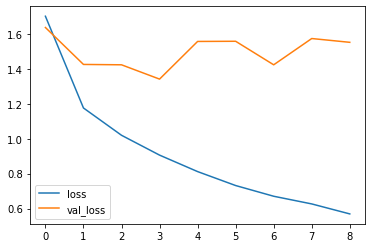

In [15]:
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.legend();

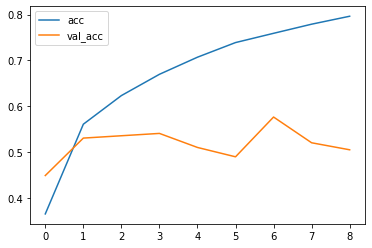

In [16]:
plt.plot(history.history["acc"], label = "acc")
plt.plot(history.history["val_acc"], label = "val_acc")
plt.legend();